셀프 주유소가 저렴한지 분석.

In [ ]:
!pip install googlemaps

In [ ]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import json
import folium
import googlemaps
import numpy as np

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도

In [ ]:
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False # - 깨짐을 방지

NanumBarunGothic


In [ ]:
fm._rebuild()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 필요한 다수의 파일이 있는 경로를 추출
station_files = glob("./data/지역_위치별*.xls")
station_files

['/content/drive/MyDrive/Encore/데이터분석/Self_Oil/data/지역_위치별(주유소) (22).xls',
 '/content/drive/MyDrive/Encore/데이터분석/Self_Oil/data/지역_위치별(주유소) (16).xls',
 '/content/drive/MyDrive/Encore/데이터분석/Self_Oil/data/지역_위치별(주유소) (11).xls',
 '/content/drive/MyDrive/Encore/데이터분석/Self_Oil/data/지역_위치별(주유소) (14).xls',
 '/content/drive/MyDrive/Encore/데이터분석/Self_Oil/data/지역_위치별(주유소) (3).xls',
 '/content/drive/MyDrive/Encore/데이터분석/Self_Oil/data/지역_위치별(주유소) (18).xls',
 '/content/drive/MyDrive/Encore/데이터분석/Self_Oil/data/지역_위치별(주유소) (19).xls',
 '/content/drive/MyDrive/Encore/데이터분석/Self_Oil/data/지역_위치별(주유소) (1).xls',
 '/content/drive/MyDrive/Encore/데이터분석/Self_Oil/data/지역_위치별(주유소) (15).xls',
 '/content/drive/MyDrive/Encore/데이터분석/Self_Oil/data/지역_위치별(주유소) (2).xls',
 '/content/drive/MyDrive/Encore/데이터분석/Self_Oil/data/지역_위치별(주유소) (2

In [ ]:
# 반복문 실행에 대한 진행율 표시(Console) %
from tqdm import tqdm_notebook

In [ ]:
# 총 24개의 엑셀 파일들을 로드(읽기)
tmp_raw = []

# 각 엑셀파일들을 읽어 데이터프레임으로 저장한 후, tmp_raw 리스트 추가
for file_name in station_files:
    tmp = pd.read_excel(file_name, header=2)
    tmp_raw.append(tmp)

In [ ]:
# tmp_raw 리스트의 각 항목에 해당하는 데이터프레임을 하나의 데이터프레임으로 연결
# 리스트의 각 항목(데이터프레임)을 하나의 데이터프레임으로 연결 => Pandas.concat(리스트)
station_raw = pd.concat(tmp_raw)
station_raw.shape

(491, 10)

In [ ]:
station_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491 entries, 0 to 21
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지역      491 non-null    object
 1   상호      491 non-null    object
 2   주소      491 non-null    object
 3   상표      491 non-null    object
 4   전화번호    491 non-null    object
 5   셀프여부    491 non-null    object
 6   고급휘발유   491 non-null    object
 7   휘발유     491 non-null    object
 8   경유      491 non-null    object
 9   실내등유    491 non-null    object
dtypes: object(10)
memory usage: 42.2+ KB


In [ ]:
stations = pd.DataFrame({'Oil_store':station_raw['상호'],
                         '주소':station_raw['주소'],
                         '가격':station_raw['휘발유'],
                         '셀프':station_raw['셀프여부'],
                         '상표':station_raw['상표']})

In [ ]:
# '구' 칼럼 추가
stations['구'] = [eachAddress.split()[1] for eachAddress in stations['주소']]

In [ ]:
stations.columns

Index(['Oil_store', '주소', '가격', '셀프', '상표', '구'], dtype='object')

In [ ]:
stations.head(3)

,Oil_store,주소,가격,셀프,상표,구
0,(주)지에스이앤알 평창주유소,서울특별시 종로구 평창문화로 135 (평창동),1669,N,현대오일뱅크,종로구
1,구도일주유소특종,서울특별시 종로구 평창문화로 90 (평창동),1699,N,S-OIL,종로구
2,자하문주유소,서울 종로구 자하문로 248 (부암동),1890,N,SK에너지,종로구


In [ ]:
stations['구'].unique() # 구가 아닌 값 => 서울특별시, 특별시

array(['종로구', '성북구', '동작구', '서초구', '강서구', '양천구', '영등포구', '강동구', '성동구',
       '서울특별시', '강북구', '용산구', '서대문구', '동대문구', '송파구', '마포구', '중랑구', '은평구',
       '관악구', '중구', '도봉구', '특별시', '금천구', '노원구', '광진구', '구로구'],
      dtype=object)

In [ ]:
stations[stations['구']=='서울특별시']

,Oil_store,주소,가격,셀프,상표,구
12,SK네트웍스(주)효진주유소,1 서울특별시 성동구 동일로 129 (성수동2가),1654,N,SK에너지,서울특별시


In [ ]:
# stations 데이터프레임에서 stations['구'] == '서울특별시' 조건에 해당하는 '구' 값을 '성동구'로 변경
stations.loc[stations['구'] == '서울특별시', '구'] = '성동구'

In [ ]:
stations['구'].unique()

array(['종로구', '성북구', '동작구', '서초구', '강서구', '양천구', '영등포구', '강동구', '성동구',
       '강북구', '용산구', '서대문구', '동대문구', '송파구', '마포구', '중랑구', '은평구', '관악구',
       '중구', '도봉구', '특별시', '금천구', '노원구', '광진구', '구로구'], dtype=object)

In [ ]:
stations[stations['구']=='특별시']

,Oil_store,주소,가격,셀프,상표,구
10,서현주유소,서울 특별시 도봉구 방학로 142 (방학동),1524,Y,S-OIL,특별시


In [ ]:
stations.loc[stations['구'] == '특별시', '구'] = '도봉구'

In [ ]:
stations['구'].unique()

array(['종로구', '성북구', '동작구', '서초구', '강서구', '양천구', '영등포구', '강동구', '성동구',
       '강북구', '용산구', '서대문구', '동대문구', '송파구', '마포구', '중랑구', '은평구', '관악구',
       '중구', '도봉구', '금천구', '노원구', '광진구', '구로구'], dtype=object)

In [ ]:
# '가격' 칼럼에 대한 결측치 확인
# '가격' 칼럼에 '-'가 있는지 확인
stations[stations['가격'] == '-']

,Oil_store,주소,가격,셀프,상표,구
33,하나주유소,서울특별시 영등포구 도림로 236 (신길동),-,N,S-OIL,영등포구
18,명진석유(주)동서울주유소,서울특별시 강동구 천호대로 1456 (상일동),-,Y,GS칼텍스,강동구
12,(주)에이앤이청담주유소,서울특별시 강북구 도봉로 155 (미아동),-,Y,SK에너지,강북구
13,송정주유소,서울특별시 강북구 인수봉로 185 (수유동),-,N,자가상표,강북구


In [ ]:
# 가격 칼럼에 '-'가 아닌 데이터들만 추출하여 다시 데이터프레임으로 재저장
stations = stations[stations['가격'] != '-']
stations[stations['가격'] == '-']

,Oil_store,주소,가격,셀프,상표,구


In [ ]:
# '가격' 칼럼의 데이터를 실수로 변환
stations['가격'] = [float(value) for value in stations['가격']]
stations['가격'].head()

0    1669.0
1    1699.0
2    1890.0
3    1960.0
4    1960.0
Name: 가격, dtype: float64

In [ ]:
stations['가격'].tail()

17    1638.0
18    1669.0
19    1697.0
20    1699.0
21    2026.0
Name: 가격, dtype: float64

In [ ]:
# stations의 내부 index를 초기화
stations.reset_index(inplace=True)
stations.index

RangeIndex(start=0, stop=487, step=1)

In [ ]:
# 데이터영역으로 나와있는 'index' 칼럼 제거
del stations['index']
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487 entries, 0 to 486
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Oil_store  487 non-null    object 
 1   주소         487 non-null    object 
 2   가격         487 non-null    float64
 3   셀프         487 non-null    object 
 4   상표         487 non-null    object 
 5   구          487 non-null    object 
dtypes: float64(1), object(5)
memory usage: 23.0+ KB


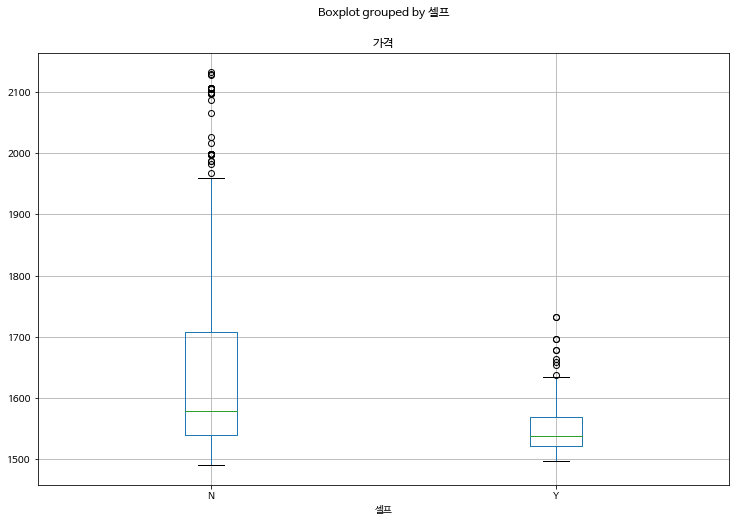

In [ ]:
# 셀프 주유소가 저렴한지 boxplot으로 확인
stations.boxplot(column='가격', by='셀프', figsize=(12, 8))

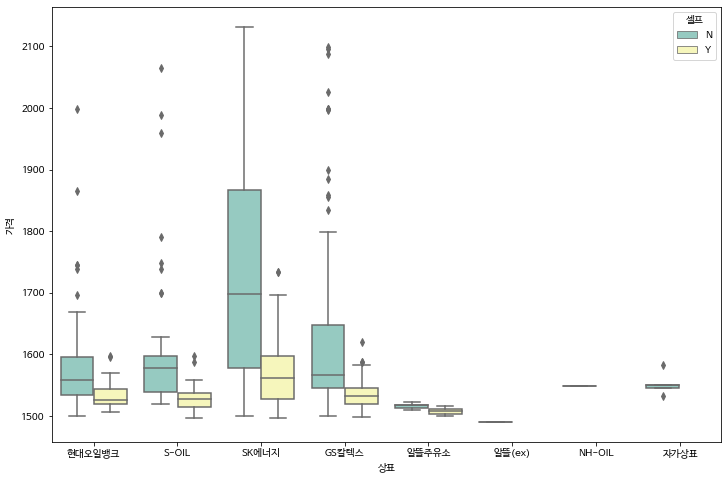

In [ ]:
# seaborn의 boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='상표', y='가격', hue='셀프', data=stations, palette='Set3')

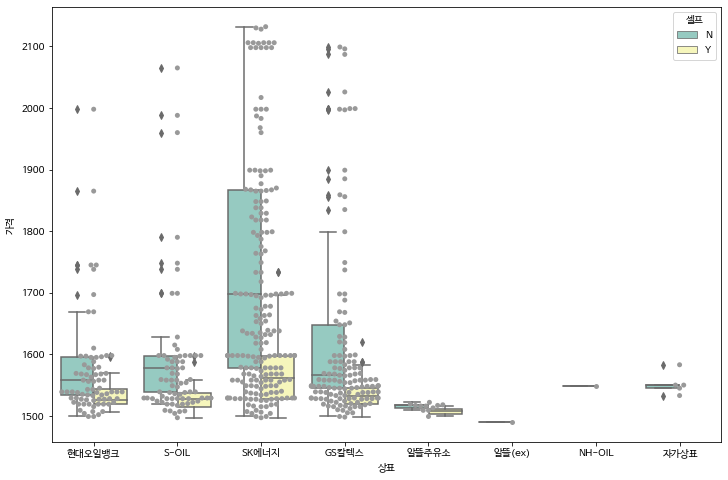

In [ ]:
# swarmplot()
plt.figure(figsize=(12, 8))
sns.boxplot(x='상표', y='가격', hue='셀프', data=stations, palette='Set3')
sns.swarmplot(x='상표', y='가격', data=stations, color='0.6')

결론 : 휘발유 가격으로만 분석했을 경우, 전반적으로 셀프 주유 가격이 더 저렴하다

### 서울시 구별 주유 가격 확인

In [ ]:
# 가격 컬럼을 기준으로 데이터 정렬
stations.sort_values(by='가격', ascending=False).head(10)

,Oil_store,주소,가격,셀프,상표,구
396,서남주유소,서울 중구 통일로 30 (봉래동1가),2132.0,N,SK에너지,중구
395,장충주유소,서울 중구 장충단로 202 (장충동1가),2130.0,N,SK에너지,중구
85,양재주유소,서울 서초구 바우뫼로 178 (양재동),2128.0,N,SK에너지,서초구
243,청파주유소,서울특별시 용산구 청파로 311 (청파동1가),2106.0,N,SK에너지,용산구
241,강변주유소,서울특별시 용산구 원효로 9 (청암동),2106.0,N,SK에너지,용산구
394,통일주유소,서울 중구 동호로 296 (장충동2가),2106.0,N,SK에너지,중구
8,재동주유소,서울특별시 종로구 율곡로 58 (경운동),2106.0,N,SK에너지,종로구
242,갈월동주유소,서울특별시 용산구 한강대로 322 (갈월동),2106.0,N,SK에너지,용산구
240,흥국주유소,서울 용산구 한남대로 204 (한남동),2105.0,N,SK에너지,용산구
393,필동주유소,서울특별시 중구 퇴계로 196 (필동2가),2099.0,N,GS칼텍스,중구


In [ ]:
# '구'별 '가격'을 비교하기 위해 index를 구 이름으로 : pandas.pivot_table()
gu_data = pd.pivot_table(stations, index=['구'], values='가격', aggfunc=np.mean)

gu_data : 데이터프레임을 생성하는 stations 데이터프레임으로부터 '구'칼럼 값을 gu_data의 index값으로, '가격'칼럼 값은 '구'별 '가격' 평균값(np.mean)으로 이용

In [ ]:
# 구글 맵 데이터 로드 : 02. skorea_municipalities_geo_simple.json
geo_path = './data/02. skorea_municipalities_geo_simple.json'

##### json 파일 읽기
1. open("파일 경로 및 파일명", encoding=인코딩방식)
2. open() 으로 열어놓은 파일을 json.load()로 읽기
3. 작업을 위해 변수에 저장. json.load()는 내부 형식에 따라
전체 타입은 리스트 => 리스트의 각 항목 타입은 딕셔너리.

In [ ]:
geo_str = json.load(open(geo_path, encoding="utf-8"))

##### folium을 활용한 시각화 - 지도
* folium은 시각화 결과를 html 파일로 저장하여 사용 => 웹 페이지에서 사용할 수 있는 상태로 저장, 따라서 folium의 시각화 내용은 변수에 저장하여 html 파일로 만들어 사용.

        1. 저장변수 = folium.Map(location=[위도, 경도], zoom_start="초기확대비율", tiles="지도종류")
        2. 저장변수.save("저장할 경로 및 파일명.html)


In [ ]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="Stamen Toner")
map

##### 기본 구글 지도 위에 행정 구역을 그리고, 각 구의 평균 가격을 생각으로 표현
    1. 저장 변수 = folium.Map(location=[위도, 경도], zoom_start="초기확대비율", tiles="지도종류")
    2. 저장변수.chropleth(geo_data="행정구역데이터",
                        data="시각화할데이터(가격)",
                        columns=[시각화할데이터.index, '가격'],
                        fill_color="데이터를 표현할 색종류",    # PuRd / YlGnBu
                        key_on="기준(feature.id)")
    3. 저장변수.save("저장경로 및 파일명.html")

In [ ]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="Stamen Toner")
map.choropleth(geo_data=geo_str,
               data=gu_data,
               columns=[gu_data.index, '가격'],
               fill_color="PuRd",
               key_on="feature.id")
map

In [ ]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="Stamen Toner")
map.choropleth(geo_data=geo_str,
               data=gu_data,
               columns=[gu_data.index, '가격'],
               fill_color="YlGnBu",
               key_on="feature.id")
map

In [ ]:
map_sample = folium.Map(location=[45.5236, -122.6750], zoom_start=13)

folium.RegularPolygonMarker([45.5012, -122.6655], popup="Ross Island Bridge", fill_color="#132b5e", number_of_sides=3, radius=10).add_to(map_sample)
folium.RegularPolygonMarker([45.5132, -122.6708], popup="Hawthorne Bridge", fill_color="#45647d", number_of_sides=4, radius=10).add_to(map_sample)
folium.RegularPolygonMarker([45.5275, -122.6692], popup="Steel Bridge", fill_color="#769d96", number_of_sides=6, radius=10).add_to(map_sample)
folium.RegularPolygonMarker([45.5318, -122.6745], popup="Broadway Bridge", fill_color="#769d96", number_of_sides=8, radius=10).add_to(map_sample)

map_sample

#### 서울시 주유 가격 상하위 10개 주유소 지도에 표기

In [ ]:
# 서울시 주유 가격 상하위 10개 데이터 추출
oil_price_top10 = stations.sort_values(by='가격', ascending=False).head(10)
oil_price_top10

,Oil_store,주소,가격,셀프,상표,구
396,서남주유소,서울 중구 통일로 30 (봉래동1가),2132.0,N,SK에너지,중구
395,장충주유소,서울 중구 장충단로 202 (장충동1가),2130.0,N,SK에너지,중구
85,양재주유소,서울 서초구 바우뫼로 178 (양재동),2128.0,N,SK에너지,서초구
243,청파주유소,서울특별시 용산구 청파로 311 (청파동1가),2106.0,N,SK에너지,용산구
241,강변주유소,서울특별시 용산구 원효로 9 (청암동),2106.0,N,SK에너지,용산구
394,통일주유소,서울 중구 동호로 296 (장충동2가),2106.0,N,SK에너지,중구
8,재동주유소,서울특별시 종로구 율곡로 58 (경운동),2106.0,N,SK에너지,종로구
242,갈월동주유소,서울특별시 용산구 한강대로 322 (갈월동),2106.0,N,SK에너지,용산구
240,흥국주유소,서울 용산구 한남대로 204 (한남동),2105.0,N,SK에너지,용산구
393,필동주유소,서울특별시 중구 퇴계로 196 (필동2가),2099.0,N,GS칼텍스,중구


In [ ]:
oil_price_bottom10 = stations.sort_values(by='가격', ascending=False).tail(10)
oil_price_bottom10

,Oil_store,주소,가격,셀프,상표,구
148,(주)대청에너지 대청주유소,서울 영등포구 가마산로 328 (대림동),1499.0,N,GS칼텍스,영등포구
465,풀페이주유소,서울특별시 구로구 경인로 41 (온수동),1499.0,N,SK에너지,구로구
32,서경주유소,서울 동작구 대림로 46 (신대방동),1499.0,N,현대오일뱅크,동작구
149,(주)강서오일,서울 영등포구 도신로 151 (도림동),1499.0,N,현대오일뱅크,영등포구
330,신일셀프주유소,서울 중랑구 상봉로 58 (망우동),1499.0,Y,SK에너지,중랑구
147,도림주유소,서울 영등포구 도림로 343 (도림동),1499.0,Y,알뜰주유소,영등포구
216,수유동주유소,서울특별시 강북구 도봉로 395 (수유동),1498.0,Y,GS칼텍스,강북구
86,강서오곡셀프주유소,서울특별시 강서구 벌말로 254 (오곡동),1497.0,Y,SK에너지,강서구
431,태릉솔밭주유소,서울특별시 노원구 노원로 49 (공릉동),1497.0,Y,S-OIL,노원구
44,만남의광장주유소,서울 서초구 양재대로12길 73-71 (원지동),1490.0,N,알뜰(ex),서초구


In [ ]:
# 반복문 실행에 대한 진행율 표시(Console) %
# from tqdm import tqdm_notebook

# 구글 맵 API Key
gmap_key = "API KEY" 
gmaps = googlemaps.Client(key=gmap_key)

In [ ]:
# 상위 10개 주유소 주소를 이용하여 위도/경도를 추출
lat = []
lng = []

In [ ]:
for n in tqdm_notebook(oil_price_top10.index):
    try:
        tmp_add = str(oil_price_top10['주소'][n]).split('(')[0]
        tmp_map = gmaps.geocode(tmp_add)

        tmp_loc = tmp_map[0].get('geometry')
        lat.append(tmp_loc['location']['lat'])
        lng.append(tmp_loc['location']['lng'])  
    except:
        lat.append(np.nan)
        lng.append(np.nan)
        print("Here is nan !")

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# 추출된 위도/경도를 데이터 프레임에 추가        
oil_price_top10['lat'] = lat
oil_price_top10['lng'] = lng
oil_price_top10

,Oil_store,주소,가격,셀프,상표,구,lat,lng
396,서남주유소,서울 중구 통일로 30 (봉래동1가),2132.0,N,SK에너지,중구,37.558348,126.972090
395,장충주유소,서울 중구 장충단로 202 (장충동1가),2130.0,N,SK에너지,중구,37.562719,127.007010
85,양재주유소,서울 서초구 바우뫼로 178 (양재동),2128.0,N,SK에너지,서초구,37.478071,127.039610
243,청파주유소,서울특별시 용산구 청파로 311 (청파동1가),2106.0,N,SK에너지,용산구,37.547451,126.969904
241,강변주유소,서울특별시 용산구 원효로 9 (청암동),2106.0,N,SK에너지,용산구,37.534910,126.945869
394,통일주유소,서울 중구 동호로 296 (장충동2가),2106.0,N,SK에너지,중구,37.560714,127.003177
8,재동주유소,서울특별시 종로구 율곡로 58 (경운동),2106.0,N,SK에너지,종로구,37.576388,126.985851
242,갈월동주유소,서울특별시 용산구 한강대로 322 (갈월동),2106.0,N,SK에너지,용산구,37.546955,126.972218
240,흥국주유소,서울 용산구 한남대로 204 (한남동),2105.0,N,SK에너지,용산구,37.545904,127.002858
393,필동주유소,서울특별시 중구 퇴계로 196 (필동2가),2099.0,N,GS칼텍스,중구,37.560850,126.993653


In [ ]:
# 하위 10개 주유소 주소를 이용하여 위도/경도를 추출
lat = []
lng = []

for n in tqdm_notebook(oil_price_bottom10.index):
    try:
        tmp_add = oil_price_bottom10['주소'][n].split('(')[0]
        tmp_map = gmaps.geocode(tmp_add)

        tmp_loc = tmp_map[0]['geometry']
        lat.append(tmp_loc['location']['lat'])
        lng.append(tmp_loc['location']['lng'])
        
    except:
        lat.append(np.nan)
        lng.append(np.nan)
        print("Here is nan !")
  
# 추출된 위도/경도를 데이터 프레임에 추가   
oil_price_bottom10['lat'] = lat
oil_price_bottom10['lng'] = lng
oil_price_bottom10

  0%|          | 0/10 [00:00<?, ?it/s]

,Oil_store,주소,가격,셀프,상표,구,lat,lng
148,(주)대청에너지 대청주유소,서울 영등포구 가마산로 328 (대림동),1499.0,N,GS칼텍스,영등포구,37.498556,126.895791
465,풀페이주유소,서울특별시 구로구 경인로 41 (온수동),1499.0,N,SK에너지,구로구,37.491009,126.826675
32,서경주유소,서울 동작구 대림로 46 (신대방동),1499.0,N,현대오일뱅크,동작구,37.487947,126.908240
149,(주)강서오일,서울 영등포구 도신로 151 (도림동),1499.0,N,현대오일뱅크,영등포구,37.509969,126.908231
330,신일셀프주유소,서울 중랑구 상봉로 58 (망우동),1499.0,Y,SK에너지,중랑구,37.590907,127.093834
147,도림주유소,서울 영등포구 도림로 343 (도림동),1499.0,Y,알뜰주유소,영등포구,37.507656,126.900191
216,수유동주유소,서울특별시 강북구 도봉로 395 (수유동),1498.0,Y,GS칼텍스,강북구,37.642140,127.029568
86,강서오곡셀프주유소,서울특별시 강서구 벌말로 254 (오곡동),1497.0,Y,SK에너지,강서구,37.555284,126.768567
431,태릉솔밭주유소,서울특별시 노원구 노원로 49 (공릉동),1497.0,Y,S-OIL,노원구,37.625918,127.085533
44,만남의광장주유소,서울 서초구 양재대로12길 73-71 (원지동),1490.0,N,알뜰(ex),서초구,37.459906,127.042060


In [ ]:
# folium 을 이용하여 지도위에 주유소 위치 marking
map = folium.Map(location=[37.5202, 126.975], zoom_start=10.5)

for n in oil_price_top10.index:
    if pd.notnull(oil_price_top10['lat'][n]):
        folium.CircleMarker([oil_price_top10['lat'][n], oil_price_top10['lng'][n]], 
                                  radius=15, color='#CD3181', 
                                  fill_color='#CD3181',
                                  fill=True).add_to(map)
    
for n in oil_price_bottom10.index:
    if pd.notnull(oil_price_bottom10['lat'][n]): 
        folium.CircleMarker([oil_price_bottom10['lat'][n], 
                                  oil_price_bottom10['lng'][n]], 
                                  radius=15, color='#3186cc', 
                                  fill_color='#3186cc',
                                  fill=True).add_to(map)

In [ ]:
map

In [ ]:
# map.save('./result/주유소 위치.html')

# import webbrowser
# webbrowser.open_new('./result/주유소 위치.html')